# 2.2 Reference Matching Pipeline - Data Labelling

Notebook này thực hiện các bước:
1. **Data Cleaning**: Tiền xử lý văn bản để chuẩn bị matching
2. **Data Labelling**: Tạo groundtruth từ BibTeX và references.json
3. **Analysis**: Phân tích kết quả matching

In [1]:
import os
import re
import json
from pathlib import Path
from typing import Dict, List, Tuple
from difflib import SequenceMatcher
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt

# Set data directory
DATA_DIR = Path(r'd:/Coding/KHDL/IntroDS_Milestone2/2210_16298-2211_3000')
OUTPUT_DIR = Path(r'd:/Coding/KHDL/IntroDS_Milestone2/outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

## 2.2.1 Data Cleaning

Các bước tiền xử lý văn bản bao gồm:
- Loại bỏ LaTeX commands
- Chuyển về lowercase
- Loại bỏ dấu (diacritics)
- Loại bỏ ký tự đặc biệt
- Chuẩn hóa khoảng trắng

In [2]:
def normalize_text(text: str) -> str:
    """Chuẩn hóa văn bản: lowercase, remove diacritics, remove punctuation."""
    if not text:
        return ""
    # Remove LaTeX commands
    text = re.sub(r'\\[a-zA-Z]+\{([^}]*)\}', r'\1', text)
    text = re.sub(r'[\\{}]', '', text)
    # Lowercase
    text = text.lower()
    # Remove accents/diacritics
    text = unicodedata.normalize('NFKD', text)
    text = ''.join(c for c in text if not unicodedata.combining(c))
    # Remove punctuation except spaces
    text = re.sub(r'[^\w\s]', ' ', text)
    # Normalize whitespace
    text = ' '.join(text.split())
    return text

# Demo
sample = "Deep Learning for {NLP}: A \\textbf{Comprehensive} Review"
print(f"Original: {sample}")
print(f"Normalized: {normalize_text(sample)}")

Original: Deep Learning for {NLP}: A \textbf{Comprehensive} Review
Normalized: deep learning for nlp a comprehensive review


In [3]:
def parse_bibtex(bib_content: str) -> Dict[str, Dict]:
    """Parse BibTeX content và trả về dictionary của các entries."""
    entries = {}
    entry_pattern = r'@(\w+)\s*\{\s*([^,\s]+)\s*,([^@]*?)(?=@|\Z)'
    
    for match in re.finditer(entry_pattern, bib_content, re.DOTALL | re.IGNORECASE):
        entry_type = match.group(1).lower()
        citation_key = match.group(2).strip()
        fields_str = match.group(3)
        
        if entry_type == 'string':
            continue
        
        fields = {}
        field_pattern = r'(\w+)\s*=\s*(?:\{([^{}]*(?:\{[^{}]*\}[^{}]*)*)\}|"([^"]*)"|\{([^}]*)\}|(\d+))'
        
        for field_match in re.finditer(field_pattern, fields_str, re.IGNORECASE | re.DOTALL):
            field_name = field_match.group(1).lower()
            field_value = next((g for g in field_match.groups()[1:] if g is not None), '')
            fields[field_name] = field_value.strip()
        
        if fields:
            entries[citation_key] = {
                'type': entry_type,
                'title': fields.get('title', ''),
                'author': fields.get('author', ''),
                'year': fields.get('year', ''),
            }
    
    return entries

def load_bib_files(paper_dir: Path) -> Dict[str, Dict]:
    """Load tất cả file .bib trong thư mục tex/ của một paper."""
    all_entries = {}
    tex_dir = paper_dir / 'tex'
    
    if not tex_dir.exists():
        return all_entries
    
    for bib_file in tex_dir.rglob('*.bib'):
        try:
            if bib_file.stat().st_size > 1000000:
                continue
            with open(bib_file, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
            entries = parse_bibtex(content)
            all_entries.update(entries)
        except Exception as e:
            print(f"Error reading {bib_file}: {e}")
    
    return all_entries

def load_references_json(paper_dir: Path) -> Dict[str, Dict]:
    """Load references.json."""
    ref_file = paper_dir / 'references.json'
    if not ref_file.exists():
        return {}
    
    try:
        with open(ref_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            if data is None:
                return {}
            return {k: v for k, v in data.items() if v is not None and isinstance(v, dict)}
    except Exception as e:
        print(f"Error reading {ref_file}: {e}")
        return {}

## 2.2.2 Data Labelling

### Matching Strategy
1. **Title Similarity**: Sử dụng SequenceMatcher để tính độ tương đồng giữa title trong BibTeX và references.json
2. **Threshold**: Match được chấp nhận khi similarity score >= 0.7

In [4]:
def calculate_similarity(text1: str, text2: str) -> float:
    """Tính similarity score giữa hai chuỗi."""
    if not text1 or not text2:
        return 0.0
    norm1 = normalize_text(text1)
    norm2 = normalize_text(text2)
    return SequenceMatcher(None, norm1, norm2).ratio()

def match_bibtex_to_arxiv(
    bib_entries: Dict[str, Dict],
    references: Dict[str, Dict],
    threshold: float = 0.7
) -> Dict[str, Tuple[str, float]]:
    """Match BibTeX entries với arXiv IDs dựa trên title similarity."""
    matches = {}
    
    for cite_key, bib_data in bib_entries.items():
        bib_title = bib_data.get('title', '')
        if not bib_title:
            continue
        
        best_match = None
        best_score = 0.0
        
        for arxiv_id, ref_data in references.items():
            ref_title = ref_data.get('title', '')
            if not ref_title:
                continue
            
            score = calculate_similarity(bib_title, ref_title)
            
            if score > best_score:
                best_score = score
                best_match = arxiv_id
        
        if best_match and best_score >= threshold:
            matches[cite_key] = (best_match, best_score)
    
    return matches

In [5]:
# Process papers and collect statistics
paper_dirs = sorted([d for d in DATA_DIR.iterdir() if d.is_dir()])[:50]

all_groundtruth = {}
all_stats = []
all_match_details = []

for paper_dir in paper_dirs:
    bib_entries = load_bib_files(paper_dir)
    references = load_references_json(paper_dir)
    
    stats = {
        'paper_id': paper_dir.name,
        'num_bib_entries': len(bib_entries),
        'num_references': len(references),
        'num_matches': 0
    }
    
    if bib_entries and references:
        matches = match_bibtex_to_arxiv(bib_entries, references, threshold=0.7)
        stats['num_matches'] = len(matches)
        
        for cite_key, (arxiv_id, score) in matches.items():
            unique_key = f"{paper_dir.name}:{cite_key}"
            all_groundtruth[unique_key] = arxiv_id
            all_match_details.append({
                'paper_id': paper_dir.name,
                'citation_key': cite_key,
                'arxiv_id': arxiv_id,
                'similarity_score': score,
                'bib_title': bib_entries[cite_key]['title'][:80],
                'ref_title': references[arxiv_id].get('title', '')[:80]
            })
    
    all_stats.append(stats)

print(f"Total papers processed: {len(paper_dirs)}")
print(f"Total groundtruth matches: {len(all_groundtruth)}")

Total papers processed: 50
Total groundtruth matches: 760


### Phân tích kết quả

In [6]:
# Convert to DataFrame for analysis
stats_df = pd.DataFrame(all_stats)
matches_df = pd.DataFrame(all_match_details)

print("=== Statistics Summary ===")
print(stats_df.describe())

=== Statistics Summary ===
       num_bib_entries  num_references  num_matches
count        50.000000       50.000000    50.000000
mean         69.720000       25.760000    15.200000
std         121.617675       35.154214    36.047588
min           0.000000        0.000000     0.000000
25%           0.000000        1.250000     0.000000
50%          24.500000       12.500000     0.000000
75%          91.750000       33.250000     4.000000
max         695.000000      145.000000   162.000000


In [7]:
# Papers với nhiều matches nhất
top_papers = stats_df[stats_df['num_matches'] > 0].sort_values('num_matches', ascending=False).head(10)
print("=== Top 10 Papers by Matches ===")
print(top_papers[['paper_id', 'num_bib_entries', 'num_references', 'num_matches']])

=== Top 10 Papers by Matches ===
      paper_id  num_bib_entries  num_references  num_matches
7   2210.16305              246             145          162
25  2210.16323              268             132          141
37  2210.16335              301             102          107
22  2210.16320              319              59           75
28  2210.16326               81              74           73
38  2210.16336              117              52           53
40  2210.16338              695              44           45
27  2210.16325               65              36           36
48  2210.16346               31              12           17
44  2210.16342               63               9           10


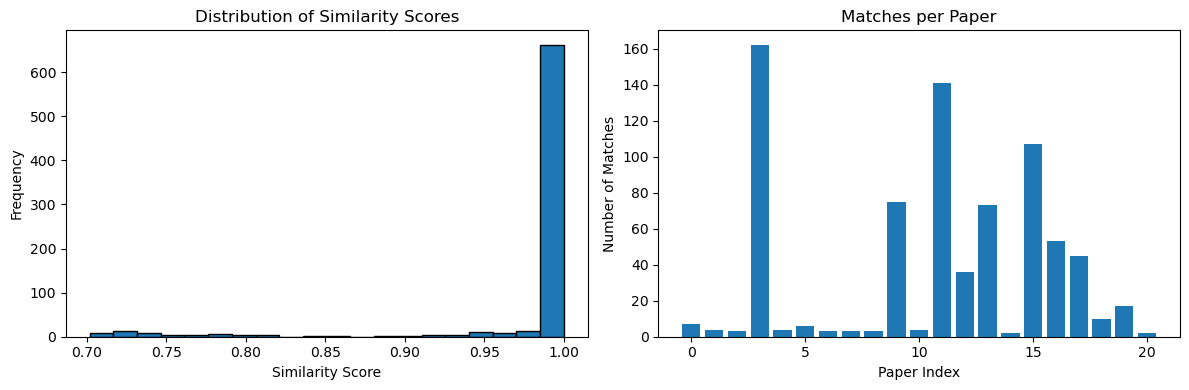

In [8]:
# Plot similarity score distribution
if len(matches_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Histogram of similarity scores
    axes[0].hist(matches_df['similarity_score'], bins=20, edgecolor='black')
    axes[0].set_xlabel('Similarity Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Similarity Scores')
    
    # Matches per paper
    papers_with_matches = stats_df[stats_df['num_matches'] > 0]
    axes[1].bar(range(len(papers_with_matches)), papers_with_matches['num_matches'])
    axes[1].set_xlabel('Paper Index')
    axes[1].set_ylabel('Number of Matches')
    axes[1].set_title('Matches per Paper')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'matching_analysis.png', dpi=150)
    plt.show()

In [9]:
# Sample matches để verify chất lượng
print("=== Sample Matches (High Confidence) ===")
if len(matches_df) > 0:
    sample = matches_df[matches_df['similarity_score'] > 0.9].head(10)
    for _, row in sample.iterrows():
        print(f"\n{row['citation_key']} -> {row['arxiv_id']} (score: {row['similarity_score']:.3f})")
        print(f"  BibTeX: {row['bib_title']}")
        print(f"  RefJSON: {row['ref_title']}")

=== Sample Matches (High Confidence) ===

williams2018broad -> 1704.05426 (score: 1.000)
  BibTeX: A Broad-Coverage Challenge Corpus for Sentence Understanding through Inference
  RefJSON: A Broad-Coverage Challenge Corpus for Sentence Understanding through Inference

hinton2015distilling -> 1503.02531 (score: 1.000)
  BibTeX: Distilling the knowledge in a neural network
  RefJSON: Distilling the Knowledge in a Neural Network

kaushik2019learning -> 1909.12434 (score: 1.000)
  BibTeX: Learning The Difference That Makes A Difference With Counterfactually-Augmented 
  RefJSON: Learning the Difference that Makes a Difference with Counterfactually-Augmented 

agrawal2018don -> 1712.00377 (score: 1.000)
  BibTeX: Don't Just Assume; Look and Answer: Overcoming Priors for Visual Question Answer
  RefJSON: Don't Just Assume; Look and Answer: Overcoming Priors for Visual Question Answer

Geirhos_2020 -> 2004.07780 (score: 1.000)
  BibTeX: Shortcut learning in deep neural networks
  RefJSON: Sho

### Export Ground Truth

In [10]:
# Create pred.json với format yêu cầu
pred_json = {
    "partition": "train",
    "groundtruth": all_groundtruth,
    "prediction": {},
    "stats": {
        "total_papers": len(paper_dirs),
        "total_matches": len(all_groundtruth),
        "threshold": 0.7,
        "per_paper_stats": all_stats
    }
}

output_file = OUTPUT_DIR / 'pred_notebook.json'
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(pred_json, f, indent=2, ensure_ascii=False)

print(f"Saved to {output_file}")
print(f"Total groundtruth entries: {len(all_groundtruth)}")

Saved to d:\Coding\KHDL\IntroDS_Milestone2\outputs\pred_notebook.json
Total groundtruth entries: 760


### Export match details to CSV for manual review

In [11]:
if len(matches_df) > 0:
    csv_file = OUTPUT_DIR / 'match_details.csv'
    matches_df.to_csv(csv_file, index=False)
    print(f"Saved match details to {csv_file}")
    print(f"Total matches: {len(matches_df)}")

Saved match details to d:\Coding\KHDL\IntroDS_Milestone2\outputs\match_details.csv
Total matches: 760


## Summary

### Phương pháp labelling:
1. **Automatic Matching**: Sử dụng title similarity với `SequenceMatcher`
2. **Threshold**: 0.7 (70% similarity)
3. **Text Preprocessing**: Lowercase, remove LaTeX, remove diacritics

### Kết quả:
- Số papers đã xử lý: _(see above)_
- Số matches tìm được: _(see above)_
- Format output: `pred.json` với groundtruth mapping